I will talk about short term reversal strategy. As I mentioned before, there are some drawbacks to momentum strategy, such as high transaction costs(shorting constraint for some countries). Stock future can be one way to cope with this problem. However, some stock future markets also have limitations since stock futures with late expiration dates are sometimes not very liquid. To make matters worse, futures also requires rollover. To reduce these risks, I will look at short term reversal. For simplicity, I will use the data, which is uploaded in my repository. 

In [1]:
import pyreadr 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We also duplicate the chunk in Momentum Strategy

In [2]:
#data_ml = pyreadr.read_r(# insert path of data_ml.RData)
data_ml.sort_values(by=['stock_id','date'], inplace=True)
stock_ids = data_ml.stock_id.unique()
stock_days = data_ml.stock_id.value_counts().sort_index() 
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)] 
data_df = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]

In [3]:
month_gap = 1     
data_df['past_R'] =  data_df.R1M_Usd.shift(month_gap)
data_df.dropna(inplace=True)
data_df.past_R = data_df.past_R.replace([np.inf, -np.inf], np.nan)
data_df.dropna(inplace = True)
momentum_num = 10
data_df['group_rank']=data_df.groupby(['date'])['past_R'].transform(
                              lambda x: pd.qcut(x, momentum_num,labels=range(momentum_num)))
monthly_return = data_df.groupby(['date','group_rank'])[['R1M_Usd','past_R']].mean()
monthly_weighted_return = monthly_return.groupby('group_rank').R1M_Usd.mean().sort_index()
monthly_weighted_return

group_rank
0.0    0.022629
1.0    0.015926
2.0    0.012979
3.0    0.014879
4.0    0.009775
5.0    0.008410
6.0    0.011560
7.0    0.007181
8.0    0.008979
9.0    0.013539
Name: R1M_Usd, dtype: float64

Then, we will make long-short portfolio. It appears that lowest momentum bin have the highest return compared to the others. Since bin 7 shows least return, I will go long on bin 0 and short on bin 7.

In [4]:
monthly_return = monthly_return.reset_index()
longshort = monthly_return[monthly_return.group_rank ==1][['date','R1M_Usd']].merge(
                     monthly_return[monthly_return.group_rank ==momentum_num-3][['date','R1M_Usd']],
                     left_on='date', right_on='date')
longshort.rename(columns={"R1M_Usd_x": "long", "R1M_Usd_y": "short"}, inplace=True)
longshort['diff'] = longshort.long -longshort.short

In [5]:
print("monthly mean return is ", longshort['diff'].mean()*100,"%")

monthly mean return is  0.8744864798046589 %


In [6]:
print("annualized sharpe ratio is ", np.sqrt(12)*(longshort['diff'].mean())/longshort['diff'].std())

annualized sharpe ratio is  0.8559524344392077


We will look at distribution of returns

array([[<AxesSubplot:title={'center':'diff'}>]], dtype=object)

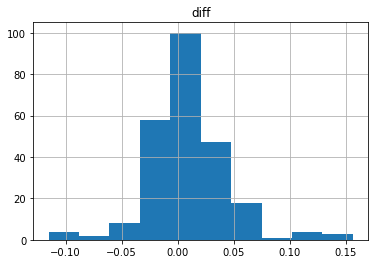

In [7]:
longshort.hist('diff')

One more thing I want to mention is bid-ask spread. This analysis assumes that futures contract can be bought and sold at same price of the underlying stock.